# PRÀCTICA 2 - CLASSIFICACIÓ

1597487 | Manuel Arnau Fernández

1600123 | Alba Fernández Coronado

1605547 | Marina Palomar González

In [37]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
import time
from yellowbrick.target import FeatureCorrelation

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")


## B. CLASSIFICACIÓ NUMÈRICA

### EDA

In [38]:
# Obrint el dataset
dataset = pd.read_csv('./weatherAUS.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.info()
dataset.head()

Mida de les dades: (145460, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 1

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Tipus de valors:  2
Valors únics:  ['No' 'Yes' nan]
No     75.839406
Yes    21.914616
Name: RainTomorrow, dtype: float64
% NaNs:  2.245978275814657


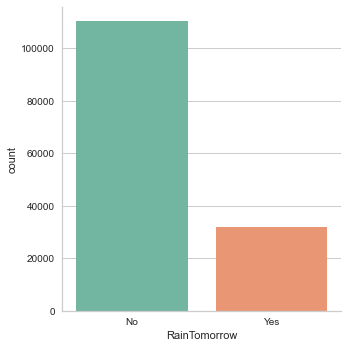

In [39]:
#Target: variable objectiu
Y = dataset['RainTomorrow']

print("Tipus de valors: ",Y.nunique()) #quants tipus de valors hi ha: 2
print("Valors únics: ",Y.unique()) #quins són els valors únics: 0, 1
print(Y.value_counts()/len(Y)*100) #percentatge de cada resposta
print("% NaNs: ",Y.isnull().sum()/len(Y)*100) #percentatge NaNs
sns.catplot(x = 'RainTomorrow', data = dataset, kind = "count", palette='Set2')

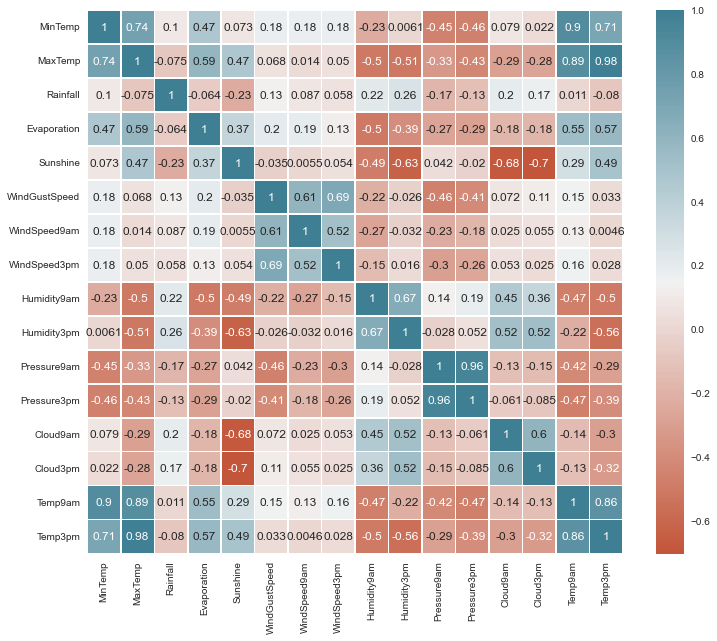

In [40]:
# Estudi de la correlació entre els atributs
correlacio = dataset.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

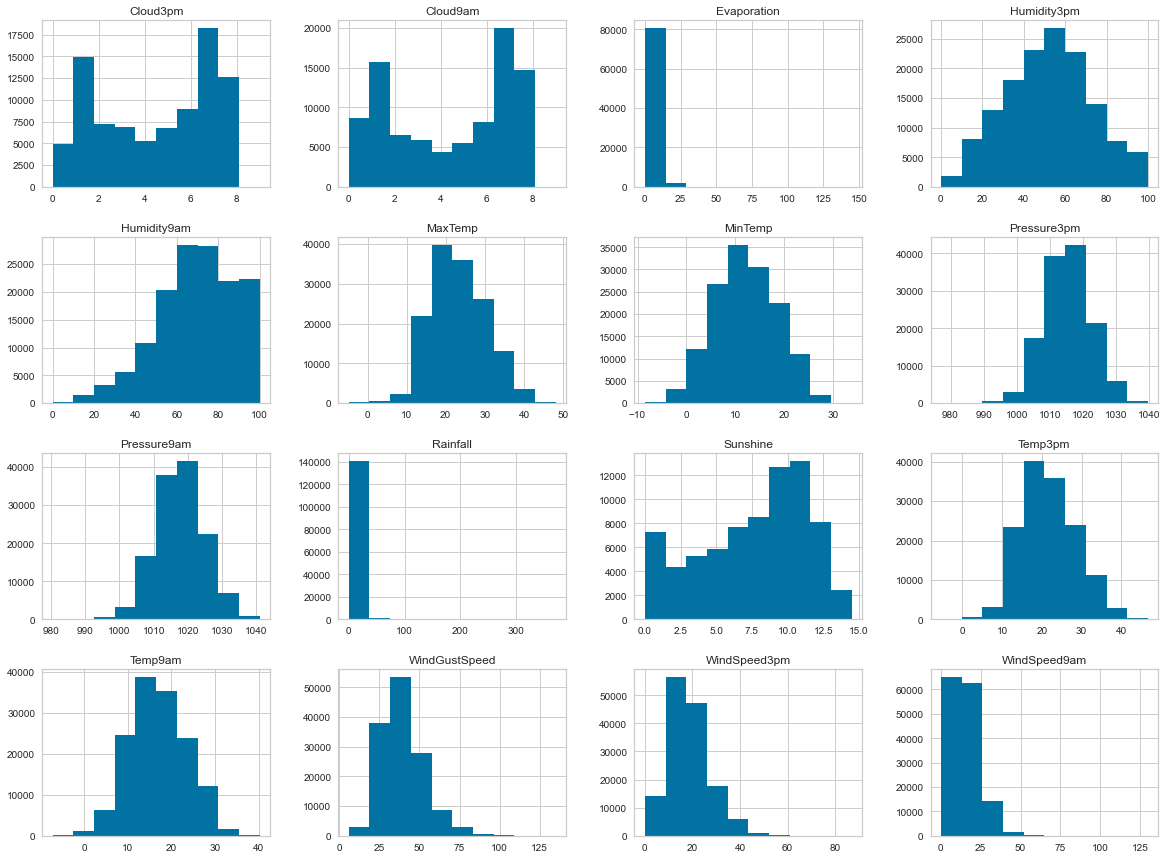

In [41]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
dataset.hist(ax=ax)
plt.show()

In [42]:
def season_replace(df):
    import datetime as dt
    month = []
    for num in df['Date']:
        date_obj = dt.datetime.strptime(num,"%Y-%m-%d")
        date_mon = date_obj.month
        month.append(date_mon)
    season_options = ['Summer', 'Summer', 'Autumn', 'Autumn', 'Autumn', 'Winter', 'Winter', 'Winter', 'Spring', 'Spring', 'Spring','Summer']
    seasons= []
    for i in month:
        seasons.append(season_options[i-1])
    n = df.columns[0]
    df.drop(n, axis = 1, inplace = True)
    df['Seasons'] = seasons
    df = df[['Seasons'] +  [col for col in df.columns if col != 'Seasons']]
    return df

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

<Figure size 576x288 with 0 Axes>

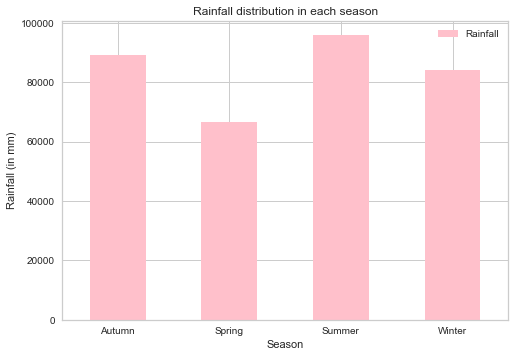

In [43]:
data = dataset.copy()
dataseason = season_replace(data)

rainfall =[dataseason['Seasons'], dataseason['Rainfall']]
headers = ['Seasons', 'Rainfall']
rain_df = pd.concat(rainfall, axis=1, keys=headers)

plt.figure(figsize=(8,4))
a = rain_df.groupby('Seasons').agg({'Rainfall':'sum'})
a.plot(kind='bar', color='pink')
plt.title('Rainfall distribution in each season')
plt.xlabel('Season')
plt.ylabel('Rainfall (in mm)')
plt.xticks(rotation=0)

### PREPROCESSING

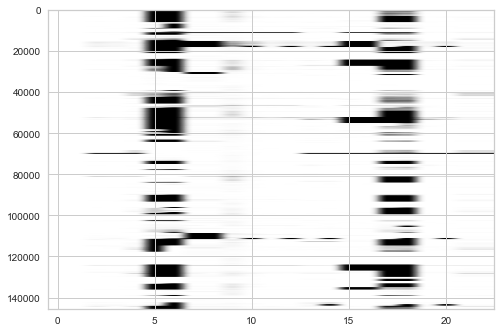

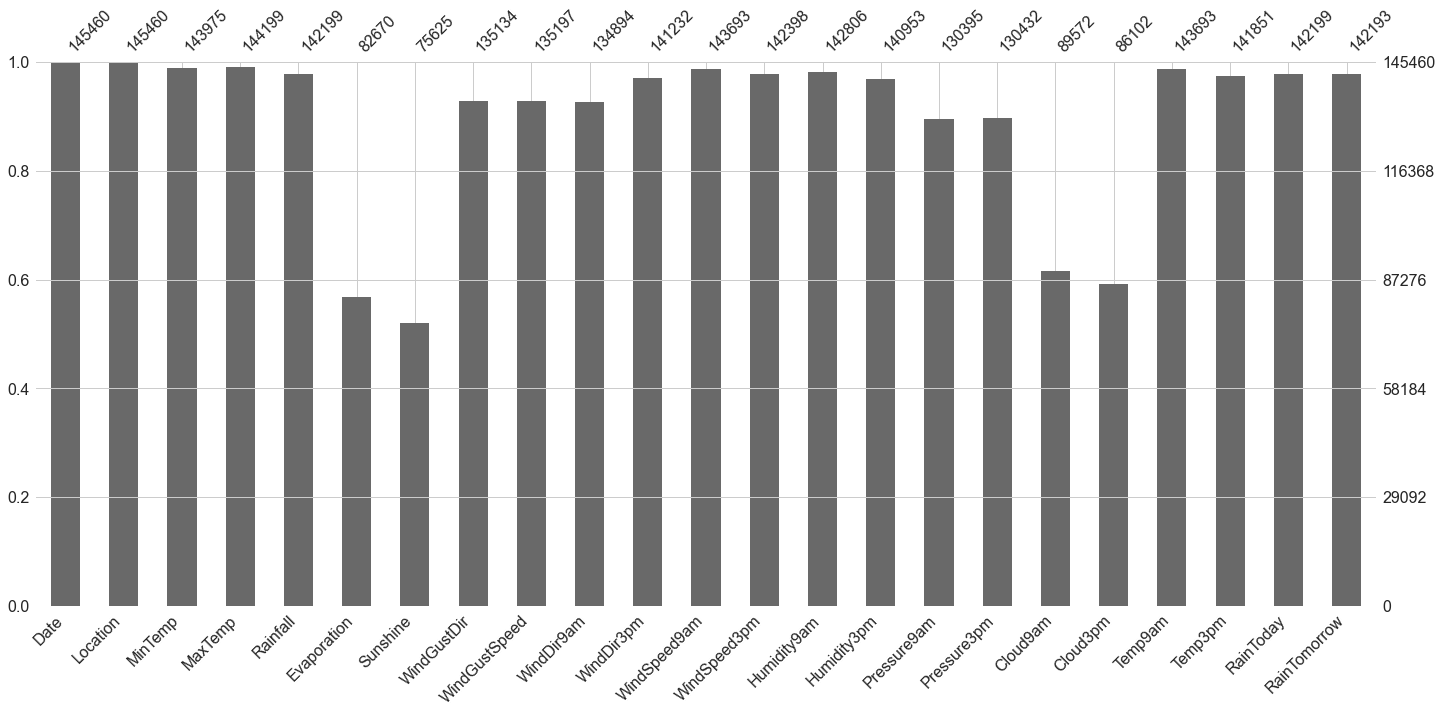

In [44]:
import missingno as msno
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
plt.imshow(dataset.isna(),aspect = 'auto')
plt.show()
# aquestes dues columnes mb tant de nans es poden eliminar pq no ens produeixen informació, segurament, 
# les seves mesures estan preses per una estació meteorologica està espatllada

# plotting the number of rows with entries per column
msno.bar(dataset)

In [45]:
#Fem una copia del dataset
dataset_cp = dataset.copy()

#Eliminem les files que continguin NaNs a la variable relacionada amb puja
# dataset_cp = dataset_cp[dataset_cp['RainTomorrow'].notna()]
# dataset_cp = dataset_cp[dataset_cp['RainToday'].notna()]
# dataset_cp = dataset_cp[dataset_cp['Rainfall'].notna()]
dataset_cp = dataset_cp.dropna(axis=0,how='any',subset=["RainTomorrow", "Rainfall", "RainToday"])

# Mirem el percentatge de NanNs de cada variable
print((dataset_cp.isnull().sum()/len(dataset_cp))*100)

#eliminem les columnes amb percentatges alts de NaNs
dataset_cp = dataset_cp.drop(['Evaporation'], axis=1)
dataset_cp = dataset_cp.drop(['Sunshine'], axis=1)
dataset_cp = dataset_cp.drop(['Cloud9am'], axis=1)
dataset_cp = dataset_cp.drop(['Cloud3pm'], axis=1)

#omplim les columnes amb un percentatge mes baix amb la moda dels valors no nulls de la columna
dataset_cp['MinTemp'].fillna(dataset_cp['MinTemp'].mode()[0], inplace=True)
dataset_cp['MaxTemp'].fillna(dataset_cp['MaxTemp'].mode()[0], inplace=True)
dataset_cp['Rainfall'].fillna(dataset_cp['Rainfall'].mode()[0], inplace=True)
dataset_cp['WindGustDir'].fillna(dataset_cp['WindGustDir'].mode()[0], inplace=True)
dataset_cp['WindGustSpeed'].fillna(dataset_cp['WindGustSpeed'].mode()[0], inplace=True)
dataset_cp['WindDir9am'].fillna(dataset_cp['WindDir9am'].mode()[0], inplace=True)
dataset_cp['WindDir3pm'].fillna(dataset_cp['WindDir3pm'].mode()[0], inplace=True)
dataset_cp['WindSpeed9am'].fillna(dataset_cp['WindSpeed9am'].mode()[0], inplace=True)
dataset_cp['WindSpeed3pm'].fillna(dataset_cp['WindSpeed3pm'].mode()[0], inplace=True)
dataset_cp['Humidity9am'].fillna(dataset_cp['Humidity9am'].mode()[0], inplace=True)
dataset_cp['Humidity3pm'].fillna(dataset_cp['Humidity3pm'].mode()[0], inplace=True) 
dataset_cp['Pressure9am'].fillna(dataset_cp['Pressure9am'].mode()[0], inplace=True)
dataset_cp['Pressure3pm'].fillna(dataset_cp['Pressure3pm'].mode()[0], inplace=True)
dataset_cp['Temp9am'].fillna(dataset_cp['Temp9am'].mode()[0], inplace=True)
dataset_cp['Temp3pm'].fillna(dataset_cp['Temp3pm'].mode()[0], inplace=True)
dataset_cp['RainToday'].fillna(dataset_cp['RainToday'].mode()[0], inplace=True)

dataset_cp['Year'] = dataset_cp['Date'].str.split("-", n=1).str[0].astype("int64")
dataset_cp['Month'] = dataset_cp['Date'].str.split("-", n=2).str[1].astype("int64")
dataset_cp['Day'] = dataset_cp['Date'].str.split("-", n=3).str[2].astype("int64")
dataset_cp = dataset_cp.drop(['Date'], axis=1)

# Es transformes totes les dades a numeriques
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset_cp.RainToday, drop_first=True, prefix='RainToday')], axis=1)
dataset_cp = dataset_cp.drop(['RainToday'], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset_cp.RainTomorrow, drop_first=True, prefix='RainTomorrow')], axis=1)
dataset_cp = dataset_cp.drop(['RainTomorrow'], axis=1)
le = LabelEncoder()
dataset_cp['Location'] = le.fit_transform(dataset_cp['Location'])
dataset_cp['WindGustDir'] = le.fit_transform(dataset_cp['WindGustDir'])
dataset_cp['WindDir9am'] = le.fit_transform(dataset_cp['WindDir9am'])
dataset_cp['WindDir3pm'] = le.fit_transform(dataset_cp['WindDir3pm'])

dataset_cp.head()

Date              0.000000
Location          0.000000
MinTemp           0.332417
MaxTemp           0.218060
Rainfall          0.000000
Evaporation      42.400222
Sunshine         47.451114
WindGustDir       6.508413
WindGustSpeed     6.467216
WindDir9am        6.861429
WindDir3pm        2.606775
WindSpeed9am      0.749359
WindSpeed3pm      1.797751
Humidity9am       1.077514
Humidity3pm       2.486735
Pressure9am       9.761555
Pressure3pm       9.780022
Cloud9am         37.379161
Cloud3pm         39.843167
Temp9am           0.465952
Temp3pm           1.863808
RainToday         0.000000
RainTomorrow      0.000000
dtype: float64


,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Month,Day,RainToday_Yes,RainTomorrow_Yes
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,...,22.0,1007.7,1007.1,16.9,21.8,2008,12,1,0,0
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,...,25.0,1010.6,1007.8,17.2,24.3,2008,12,2,0,0
2,2,12.9,25.7,0.0,15,46.0,13,15,19.0,26.0,...,30.0,1007.6,1008.7,21.0,23.2,2008,12,3,0,0
3,2,9.2,28.0,0.0,4,24.0,9,0,11.0,9.0,...,16.0,1017.6,1012.8,18.1,26.5,2008,12,4,0,0
4,2,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,...,33.0,1010.8,1006.0,17.8,29.7,2008,12,5,0,0


In [46]:
dataset_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          140787 non-null  int32  
 1   MinTemp           140787 non-null  float64
 2   MaxTemp           140787 non-null  float64
 3   Rainfall          140787 non-null  float64
 4   WindGustDir       140787 non-null  int32  
 5   WindGustSpeed     140787 non-null  float64
 6   WindDir9am        140787 non-null  int32  
 7   WindDir3pm        140787 non-null  int32  
 8   WindSpeed9am      140787 non-null  float64
 9   WindSpeed3pm      140787 non-null  float64
 10  Humidity9am       140787 non-null  float64
 11  Humidity3pm       140787 non-null  float64
 12  Pressure9am       140787 non-null  float64
 13  Pressure3pm       140787 non-null  float64
 14  Temp9am           140787 non-null  float64
 15  Temp3pm           140787 non-null  float64
 16  Year              14

In [47]:
#S'agafen tots els atributs que no siguin object
NoObj_data = dataset[dataset.select_dtypes(exclude=['object']).columns]

# Agafem la intersecció entre el dataset_cp i el dataset sense atributs objecte per tractar els outliers posteriorment
intersect = list(set(dataset_cp.columns).intersection(list(NoObj_data.columns)))
NoObj_data = dataset_cp[intersect]

NoObj_data.describe()

,WindSpeed9am,Humidity9am,Pressure9am,MaxTemp,WindGustSpeed,WindSpeed3pm,Temp9am,Temp3pm,Rainfall,Humidity3pm,Pressure3pm,MinTemp
count,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,13.953099,69.151953,1017.532111,23.228066,39.649066,18.529907,16.987127,21.661625,2.349974,51.462983,1015.281634,12.176231
std,8.863308,19.214866,6.759453,7.108341,13.188574,8.750698,6.480861,6.876640,8.465173,20.547147,6.682913,6.394957
min,0.000000,0.000000,980.500000,-4.800000,6.000000,0.000000,-7.200000,-5.400000,0.000000,0.000000,977.100000,-8.500000
25%,7.000000,57.000000,1013.500000,17.900000,31.000000,13.000000,12.300000,16.700000,0.000000,37.000000,1011.000000,7.600000
50%,13.000000,70.000000,1016.700000,22.600000,37.000000,17.000000,16.800000,20.900000,0.000000,52.000000,1015.500000,12.000000
75%,19.000000,84.000000,1021.800000,28.200000,46.000000,24.000000,21.500000,26.300000,0.800000,65.000000,1019.400000,16.800000
max,130.000000,100.000000,1041.000000,48.100000,135.000000,87.000000,40.200000,46.700000,371.000000,100.000000,1039.600000,33.900000


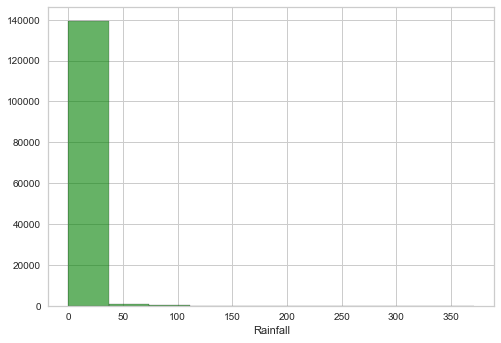

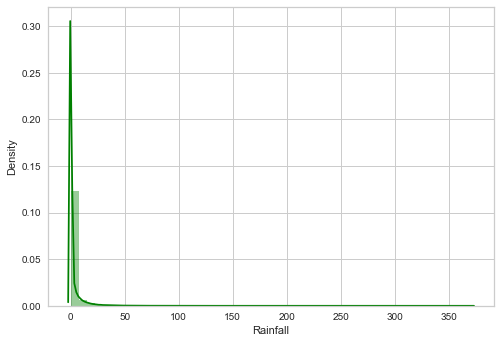

In [48]:
plt.hist(dataset_cp['Rainfall'], color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('Rainfall')
plt.show()
sns.distplot(dataset_cp['Rainfall'], color= 'green')

In [49]:
#treiem la columna Rainfall perque els valors extrems no es consideren outliers
NoObj_data = NoObj_data.drop(['Rainfall'], axis = 1)

MiceImputed = NoObj_data.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(NoObj_data)

# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.05)
Q3 = MiceImputed.quantile(0.95)
IQR = Q3 - Q1
total_outlier_num = ((NoObj_data < (Q1 - 1.5 * IQR)) | (NoObj_data > (Q3 + 1.5 * IQR))).sum()
print(total_outlier_num)

# Removing outliers from the dataset
dataset_cp = dataset_cp[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
dataset_cp.info()

WindSpeed9am     4
Humidity9am      0
Pressure9am      0
MaxTemp          0
WindGustSpeed    2
WindSpeed3pm     7
Temp9am          0
Temp3pm          0
Humidity3pm      0
Pressure3pm      0
MinTemp          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140777 entries, 0 to 145458
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          140777 non-null  int32  
 1   MinTemp           140777 non-null  float64
 2   MaxTemp           140777 non-null  float64
 3   Rainfall          140777 non-null  float64
 4   WindGustDir       140777 non-null  int32  
 5   WindGustSpeed     140777 non-null  float64
 6   WindDir9am        140777 non-null  int32  
 7   WindDir3pm        140777 non-null  int32  
 8   WindSpeed9am      140777 non-null  float64
 9   WindSpeed3pm      140777 non-null  float64
 10  Humidity9am       140777 non-null  float64
 11  Humidity3pm       140777 non-null  flo

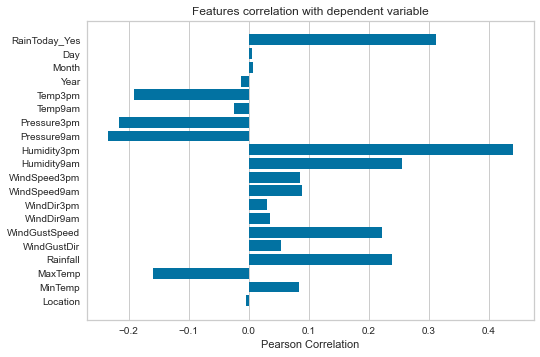

In [50]:
# Correlacio dels atributs amb la variable objectiu
X = dataset_cp.drop(['RainTomorrow_Yes'], axis=1)
Y = dataset_cp['RainTomorrow_Yes']
feature_names = list(X.columns)
visualizer = FeatureCorrelation(labels = feature_names)
visualizer.fit(X, Y)
visualizer.poof()

In [51]:
# Calculate the correlation matrix
corr = dataset_cp.corr()
corr1 = pd.DataFrame(abs(corr['RainTomorrow_Yes']),columns = ['RainTomorrow_Yes'])
nonvals = corr1.loc[corr1['RainTomorrow_Yes'] < 0.05]
print('Var correlation < 5%',nonvals)
nonvals = list(nonvals.index.values)

# We extract variables with correlation less than 5%
dataset_cp = dataset_cp.drop(columns=nonvals,axis=1)
print('Data Final',dataset_cp.shape)

Var correlation < 5%             RainTomorrow_Yes
Location            0.005287
WindDir9am          0.035950
WindDir3pm          0.029851
Temp9am             0.025396
Year                0.013068
Month               0.007192
Day                 0.005176
Data Final (140777, 14)


In [52]:
# Es separen X i Y del dataset
X = dataset_cp.drop(['RainTomorrow_Yes'], axis=1)
Y = dataset_cp['RainTomorrow_Yes']

In [53]:
#Normalitzem les dades
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_cols = X.columns
X_scale.columns = X_cols

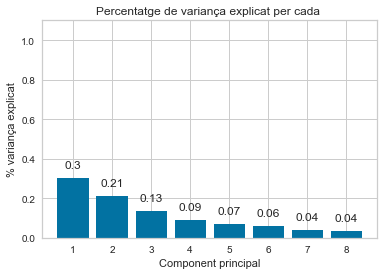

In [54]:
#es fa un pca per visualitzar els outliers
model = PCA(n_components=8)
model.fit(X_scale)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
X_pca = model.transform(X_scale)

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('% variança explicat');

#Conclusió: com les variances són molt baixes, no val la pena fer un PCA.

In [55]:
# No val la pena fer un polynomial features perque tenim masses caracteristiques i tardariem molt

### MODEL SELECTION

In [56]:
#Separem en train i test
x_train,x_test,y_train,y_test = train_test_split(X_scale,Y,test_size=0.3, random_state = 0)

In [57]:
#FEATURE SELECTION
from statsmodels.stats.outliers_influence import variance_inflation_factor

def BWSelection_VIF(Xtrain):
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = Xtrain.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(Xtrain.values, i)
                              for i in range(len(Xtrain.columns))]

    #si el valor de VIF és molt alt, hi ha molta correlacio entre variables
    if max(vif_data["VIF"]) > 5:
        X_new = Xtrain.drop(vif_data['feature'][np.argmax(vif_data["VIF"])],axis=1)
        BWSelection_VIF(X_new)
    else:
        llistaVIF.append([col for col in Xtrain])

In [58]:
llistaVIF =[]
BWSelection_VIF(X_scale)
llistaVIF = llistaVIF[0]

In [59]:
llistaVIF

['MinTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure3pm',
 'RainToday_Yes']

In [60]:
#MÚLTIPLE DECISION TREE CLASSIFIER
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed

#Treballem en paral·lel per fer un model simple per a cada atribut considerat important en el VIF_Selection
#A partir d'aquí decidirem amb quins models treballar
def MultipleDT(atribut):
    
    clf_dt = DecisionTreeClassifier(random_state=0)
    clf_dt.fit(x_train[[atribut]],y_train)
    y_pred1 = clf_dt.predict(x_test[[atribut]])
    score1 = accuracy_score(y_test,y_pred1)
    y_pred2 = clf_dt.predict(x_train[[atribut]])
    score2 = accuracy_score(y_train,y_pred2)
    return [score1,score2]

In [61]:
t0=time.time() 
result = Parallel(n_jobs = 10)(delayed(MultipleDT)(atribut) for atribut in llistaVIF)

for atribut,r in zip(llistaVIF,result): 
        print('Accuracy',atribut,':',r) #r = [acc_test, acc_train]
print('Time taken :' , time.time()-t0, "s")

print("Null accuracy: ",y_test.value_counts()[0]/sum(y_test.value_counts())) #Percentatge de 0 al y_test

Accuracy MinTemp : [0.7767438556613155, 0.7791116568401611]
Accuracy Rainfall : [0.7871620021783398, 0.7939681154419898]
Accuracy WindGustDir : [0.776814888478477, 0.77906091756898]
Accuracy WindGustSpeed : [0.7790169058104844, 0.7813035933551851]
Accuracy WindSpeed9am : [0.7766017900269925, 0.7792131353825233]
Accuracy WindSpeed3pm : [0.776814888478477, 0.7792638746537045]
Accuracy Humidity9am : [0.7764360467869489, 0.779152248257106]
Accuracy Humidity3pm : [0.82760335274897, 0.8252843936149701]
Accuracy Pressure3pm : [0.7803191741251124, 0.7835361212871539]
Accuracy RainToday_Yes : [0.776814888478477, 0.77906091756898]
Time taken : 10.594504594802856 s
Null accuracy:  0.776814888478477


In [62]:
#Fer Logistic Regression, KNN i SVM (aquests dos tarden molt en temps)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# SVM
def MultipleSVC(k):
    model = svm.SVC(kernel = k) #classificació
    model.fit(x_train[['Humidity3pm']], y_train)
    y_pred = model.predict(x_test[['Humidity3pm']])
    score = accuracy_score(y_test,y_pred)
    return score

# LOGISTIC REGRESSION
def LogReg():
    logreg = LogisticRegression(solver='saga', random_state=0)
    logreg.fit(x_train[llistaVIF], y_train)
    score_test = logreg.score(x_test[llistaVIF], y_test)
    score_train = logreg.score(x_train[llistaVIF], y_train)
    LM_cm = confusion_matrix(y_test, logreg.predict(x_test[llistaVIF]))
    return logreg, score_test, score_train, LM_cm
    
# KNN
def KNN(n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train[llistaVIF],y_train)
    score_test = knn.score(x_test[llistaVIF], y_test)
    score_train = knn.score(x_train[llistaVIF], y_train)
    KNN_cm = confusion_matrix(y_test, knn.predict(x_test[llistaVIF]))
    return knn, score_test, score_train, KNN_cm
    
#Preceptron model
def Perc():
    clf = Perceptron(random_state=0)
    clf.fit(x_train, y_train)
    score_test = clf.score(x_test,y_test)
    score_train = clf.score(x_train,y_train)
    return clf, score_test, score_train

#Random Forest
def RandomForest():
    modelrfcla = RandomForestClassifier(n_estimators=50,random_state=9,n_jobs=-1).fit(x_train[llistaVIF],y_train)
    score_test = modelrfcla.score(x_test[llistaVIF], y_test)
    score_train = modelrfcla.score(x_train[llistaVIF], y_train)
    RF_cm = confusion_matrix(y_test, modelrfcla.predict(x_test[llistaVIF]))
    return modelrfcla, score_test, score_train, RF_cm

In [64]:
# SVM
# print("MODEL SVM")
# t0=time.time()        
# kernels = ["sigmoid", "rbf"]
# result = Parallel(n_jobs = 2)(delayed(MultipleSVC)(kernel) for kernel in kernels)
# for kernel,r in zip(kernels,result):
#         print('Accuracy',kernel,':',r)
# print('Time taken :' , time.time()-t0)

# LR
print("MODEL LOGISTIC REGRESSION")
t0=time.time()  
LR, log_acctest, log_acctrain, LR_cm = LogReg()
print("Accuracy test:",log_acctest)
print("Accuracy train:",log_acctrain)
print('Time taken :' , time.time()-t0)

# KNN
print("MODEL KNN")
t0=time.time()
KNN, knn_acctest, knn_acctrain, KNN_cm = KNN()
print("Accuracy test:",knn_acctest)
print("Accuracy train:",knn_acctrain)
print('Time taken :' , time.time()-t0)

#Perceptron
print("MODEL PERCEPTRON")
t0=time.time() 
Perc, perc_acctest, perc_acctrain = Perc()
print("Accuracy test:",perc_acctest)
print("Accuracy train:",perc_acctrain)
print('Time taken :' , time.time()-t0)

#Random Forest
print("MODEL RANDOM FOREST")
t0=time.time() 
RF, RF_acctest, RF_acctrain, RF_cm = RandomForest()
print("Accuracy test:",RF_acctest)
print("Accuracy train:",RF_acctrain)
print('Time taken :' , time.time()-t0)

MODEL LOGISTIC REGRESSION
Accuracy test: 0.8417625609698347
Accuracy train: 0.8417340653318856
Time taken : 1.307814359664917
MODEL KNN
Accuracy test: 0.8333333333333334
Accuracy train: 0.8753742021249606
Time taken : 84.74486947059631
MODEL PERCEPTRON
Accuracy test: 0.6876213477293176
Accuracy train: 0.6848685345483697
Time taken : 0.263932466506958
MODEL RANDOM FOREST
Accuracy test: 0.8479424160628877
Accuracy train: 0.9993200937661731
Time taken : 6.612483739852905


### CROSSVALIDATION

In [ ]:
#ens qdem amb el logistic regression, Random forest i amb el KNN q son els millors models
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, Y)
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
i = 1
for train_index, test_index in skf.split(X_scale, Y):
   # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scale.iloc[train_index], X_scale.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    #Logistic Regression
    LR.fit(X_train[llistaVIF], Y_train)
    y_pred = LR.predict(X_test[llistaVIF])
    score = accuracy_score(Y_test, y_pred)
    print("Accuracy Logistic Model: ",score,"fold: ", i)
    
    #KNN
    KNN.fit(X_train[llistaVIF], Y_train)
    pred_test = KNN.predict(X_test[llistaVIF])
    score = accuracy_score(Y_test, pred_test)
    print("Accuracy KNN Model: ",score,"fold: ", i)
    
    #RandomForest
    RF.fit(X_train[llistaVIF], Y_train)
    pred_test = RF.predict(X_test[llistaVIF])
    score = accuracy_score(Y_test, pred_test)
    print("Accuracy RandomForest Model: ",score,"fold: ", i)
    i = i+1

#Com es pot observar, el Logistic Regression dona millors accuracys
#No  seria convenient aplicar LeaveOneOut, ja que en aquest dataset hi ha  moltes files i trigariem molt


Accuracy Logistic Model:  0.8377965620116494 fold:  1
Accuracy KNN Model:  0.8239806790737321 fold:  1
Accuracy RandomForest Model:  0.841028555192499 fold:  1
Accuracy Logistic Model:  0.8207131694843017 fold:  2
Accuracy KNN Model:  0.8085665577496803 fold:  2


### METRIC ANALYSIS

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1) 
ax1.set_title('Logistic Regression Classification') 
ax2 = fig.add_subplot(1, 3, 2) 
ax2.set_title('KNN Classification')
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Random Forest Classification')
sns.heatmap(data=LR_cm, annot=True, linewidth=0.7, linecolor='cyan',cmap="YlGnBu" ,fmt='g', ax=ax1)
sns.heatmap(data=KNN_cm, annot=True, linewidth=0.7, linecolor='cyan',cmap="YlGnBu" ,fmt='g', ax=ax2)  
sns.heatmap(data=RF_cm, annot=True, linewidth=0.7, linecolor='cyan',cmap="YlGnBu" ,fmt='g', ax=ax3)
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

#Logistic Regression
visualizerLR = ROCAUC(LR)

visualizerLR.fit(x_train[llistaVIF], y_train)        # Fit the training data to the visualizer
visualizerLR.score(x_test[llistaVIF], y_test)        # Evaluate the model on the test data
visualizerLR.show()                       # Finalize and show the figure

#KNN
visualizerKNN = ROCAUC(KNN)

visualizerKNN.fit(x_train[llistaVIF], y_train)        # Fit the training data to the visualizer
visualizerKNN.score(x_test[llistaVIF], y_test)        # Evaluate the model on the test data
visualizerKNN.show()                       # Finalize and show the figure


#RandomForest
visualizerRF = ROCAUC(RF)

visualizerRF.fit(x_train[llistaVIF], y_train)        # Fit the training data to the visualizer
visualizerRF.score(x_test[llistaVIF], y_test)        # Evaluate the model on the test data
visualizerRF.show()                       # Finalize and show the figure

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_confusion_matrix, f1_score, average_precision_score
# Compute Precision-Recall and plot curve LogisticRegression
def PrecisionRecall (model):
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()
    probs = model.predict_proba(x_test[llistaVIF])

    for i in range(2):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, probs[:, i])
        average_precision[i] = average_precision_score(y_test == i, probs[:, i])
        plt.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="upper right")
        
    plt.title(model)
    plt.show()

In [ ]:
models = [LR, KNN, RF]
for m in models:
    PrecisionRecall(m)

In [ ]:
from sklearn.metrics import classification_report
#Logistic Regression
print("LOGISTIC REGRESSION CLASSIFICATION REPORT")
print(classification_report(y_test, LR.predict(x_test[llistaVIF])))

#KNN
print("KNN CLASSIFICATION REPORT")
print(classification_report(y_test, KNN.predict(x_test[llistaVIF])))

#Random Forest
print("RANDOM FOREST CLASSIFICATION REPORT")
print(classification_report(y_test, RF.predict(x_test[llistaVIF])))

### HYPERPARAMETER SEARCH

https://www.kaggle.com/code/wolemercy/predicting-rainfall-in-australia/notebook

In [ ]:
from sklearn.model_selection import GridSearchCV

#Logistic Regression
solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
grid_search = GridSearchCV(estimator=LR, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scale[llistaVIF],Y)
# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
#KNN
n_neighbors = [1,2,5,10,15,20,25]

# define grid search
grid = dict(n_neighbors = n_neighbors)
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
grid_search = GridSearchCV(estimator=KNN, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scale[llistaVIF],Y)
# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
#Falta rf

In [ ]:
#apartat A

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

# import some data to play with
iris = datasets.load_iris()

# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

n_classes = 3
    
fig, sub = plt.subplots(1, 2, figsize=(16,6))
sub[0].scatter(X[:,0], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
sub[1].scatter(X[:,1], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')


particions = [0.5, 0.7, 0.8]

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

    # l'entrenem
    logireg.fit(x_t, y_t)

    print ("Correct classification Logistic ", part, "% of the data: ", logireg.score(x_v, y_v))
    
    #Creem el regresor logístic
    svc = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True)

    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Correct classification SVM      ", part, "% of the data: ", svc.score(x_v, y_v))


In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
    average_precision[i] = average_precision_score(y_v == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def show_C_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    iris = datasets.load_iris()
    # Take the first two features. We could avoid this by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    titles = ('SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel')

    #C = 1.0  # SVM regularization parameter
    models = (svm.SVC(kernel='linear', C=C),
              svm.LinearSVC(C=C, max_iter=1000000),
              svm.SVC(kernel='rbf', gamma=gamma, C=C),
              svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C))
    models = (clf.fit(X, y) for clf in models)

    plt.close('all')
    fig, sub = plt.subplots(2, 2, figsize=(14,9))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

#     X0, X1 = X[:, 0], X[:, 1] #petara
    X0 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
    X1 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)

    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()


In [ ]:
show_C_effect(C=0.1) # c molt gran, farà underfitting (posarà tots els coeficients a zero), train sempre ho farà pitjor, 
                    # allí on el train i test es trobin, c és la optima
                    # fer grafica C-J on J=-sum(ylog(1-yp)+(1-y)log(yp)+c*sum(h^2))